In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
import os
import csv
from helpers import *
from neural_network_model import NeuralNetwork

In [5]:
x0 = pd.read_csv('data/x_train.csv')
y0 = pd.read_csv('data/y_train.csv')
x_tr = x0.copy(deep=True)
y_tr = y0.copy(deep=True)

## Preprocessing

In [6]:
%%capture
#Converting the weights to kg, and asigning lacking answers to -1
array = x_tr["WEIGHT2"].values
pounds_indices  = ((array >= 50)*(array <= 999))
kg_indices      = ((array >= 9000)*(array <= 9998))
none_indices    = ((array == 7777) + (array == 9998))

x_tr["WEIGHT2"][pounds_indices] = 0.453592 * x_tr["WEIGHT2"][pounds_indices]
x_tr["WEIGHT2"][kg_indices] = x_tr["WEIGHT2"][kg_indices]%9000
x_tr["WEIGHT2"][none_indices] = np.nan

In [7]:
%%capture
#converting the height to meters, and asigning lacking answers to -1
array = x_tr["HEIGHT3"].values
imperial_indices    = ((array >= 200)*(array <= 711))
cm_indices          = ((array >= 9000)*(array <= 9998))
none_indices        = (array == 9998)

x_tr["HEIGHT3"][imperial_indices] = 0.3048 * x_tr["HEIGHT3"][imperial_indices]//100 + 0.0254 * x_tr["HEIGHT3"][imperial_indices]%100
x_tr["HEIGHT3"][cm_indices] = x_tr["HEIGHT3"][cm_indices]%9000
x_tr["HEIGHT3"][none_indices] = np.nan

In [8]:
#define a few functions used to clean and scale the data properly
def frequency_scaler(df, col):
    times_per_day   = (df[col]>=101)*(df[col]<=199)
    times_per_week  = (df[col]>=201)*(df[col]<=299)
    times_per_month = (df[col]>=301)*(df[col]<=399)
    none_indices    = (df[col] == 777) + (df[col] == 999)

    df[col][times_per_day]      = df[col][times_per_day]%100
    df[col][times_per_week]     = (df[col][times_per_week]%200)/7
    df[col][times_per_month]    = (df[col][times_per_month]%300)/30
    df[col][df[col]==300]       = 1/30
    df[col][df[col]==555]       = 0
    x_tr[col][none_indices] = np.nan

def weekly_frequency_scaler(df, col):
    times_per_week  = (df[col]>=101)*(df[col]<=199)
    times_per_month = (df[col]>=201)*(df[col]<=299)
    none_indices    = (df[col] == 777) + (df[col] == 999)

    df[col][times_per_week]     = (df[col][times_per_week]%100)/7
    df[col][times_per_month]    = (df[col][times_per_month]%200)/30
    df[col][df[col]==888]       = 0
    df[col][none_indices]       = np.nan

def hours_to_minutes(df, col):
    df[col][df[col].between(1, 759, "both")*df[col].between(800, 959, "both")] = 60*df[col][df[col].between(1, 759, "both")*df[col].between(800, 959, "both")]//100 + df[col][df[col].between(1, 759, "both")*df[col].between(800, 959, "both")]%100
    df[col][(df[col]==777) + (df[col]==999)] = np.nan

In [9]:
%%capture
#fix the frequency scales of the following columns
frequency_scaler(x_tr, "FRUITJU1")
frequency_scaler(x_tr, "FRUIT1")
frequency_scaler(x_tr, "FVBEANS")
frequency_scaler(x_tr, "FVGREEN")
frequency_scaler(x_tr, "FVORANG")
frequency_scaler(x_tr, "VEGETAB1")

hours_to_minutes(x_tr, "EXERHMM1")
hours_to_minutes(x_tr, "EXERHMM2")

weekly_frequency_scaler(x_tr, "ALCDAY5")
weekly_frequency_scaler(x_tr, "EXEROFT1")
weekly_frequency_scaler(x_tr, "EXEROFT2")
weekly_frequency_scaler(x_tr, "STRENGTH")

In [10]:
#A few interesting features
intresting_features=["GENHLTH","POORHLTH","HLTHPLN1","CHECKUP1","BPMEDS","TOLDHI2","CVDSTRK3","PHYSHLTH","MENTHLTH",
                     "HLTHPLN1","CVDSTRK3","CHCOCNCR","CHCCOPD1","HAVARTH3","CHCKIDNY","DIABETE3", "ASTHMA3", "ASTHNOW",
                     "CHCSCNCR", "ADDEPEV2", "DIABAGE2", "EDUCA", "INCOME2", "QLACTLM2", "USEEQUIP", "BLIND", "DECIDE",
                     "DIFFWALK", "DIFFDRES", "DIFFALON", "SMOKE100"]
dico_transfos={"GENHLTH":{7:np.nan,8:np.nan,9:np.nan},"POORHLTH":{88:0,77:np.nan,99:np.nan},"HLTHPLN1":{7:np.nan,9:np.nan},"CHECKUP1":{8:15,7:np.nan,9:np.nan},
               "BPMEDS":{7:np.nan,9:np.nan}, "TOLDHI2":{7:np.nan,9:np.nan}, "PHYSHLTH":{88:0,77:np.nan,99:np.nan},
               "MENTHLTH":{88:0,77:np.nan,99:np.nan}, "CVDSTRK3":{7:np.nan, 9:np.nan}, "HLTHPLN1":{9:np.nan}, "CHCOCNCR":{7:np.nan, 9:np.nan},
               "HAVARTH3":{7:np.nan, 9:np.nan}, "CHCKIDNY":{7:np.nan, 9:np.nan}, "DIABETE3":{7:np.nan, 9:np.nan}, "CHCCOPD1":{7:np.nan, 9:np.nan},
               "ASTHMA3":{7:np.nan, 9:np.nan}, "ASTHNOW":{7:np.nan, 9:np.nan}, "CHCSCNCR":{7:np.nan, 9:np.nan}, "ADDEPEV2":{7:np.nan, 9:np.nan},
               "DIABAGE2":{98:np.nan, 99:np.nan}, "EDUCA":{9:np.nan}, "INCOME2":{77:np.nan, 99:np.nan}, "QLACTLM2":{7:np.nan, 9:np.nan},
               "USEEQUIP":{7:np.nan, 9:np.nan}, "BLIND":{7:np.nan, 9:np.nan}, "DECIDE":{7:np.nan, 9:np.nan}, "DIFFWALK":{7:np.nan, 9:np.nan},
               "DIFFDRES":{7:np.nan, 9:np.nan}, "DIFFALON":{7:np.nan, 9:np.nan}, "SMOKE100":{7:np.nan, 9:np.nan}, "SMOKDAY2":{7:np.nan, 9:np.nan},
               "USENOW3":{7:np.nan, 9:np.nan}, "AVEDRNK2":{77:np.nan, 99:np.nan}, "DRNK3GE5":{77:np.nan, 88:np.nan, 99:np.nan}, "MAXDRNKS":{77:np.nan, 99:np.nan},
               "EXERANY2":{7:np.nan, 9:np.nan}, "EXERHMM1":{777:np.nan, 999:np.nan}, "SEATBELT":{7:np.nan, 8:np.nan, 9:np.nan}, "PNEUVAC3":{7:np.nan, 9:np.nan}}

In [11]:
x_tr_temp=x_tr.copy()
for col in dico_transfos:
    x_tr_temp[col].replace(dico_transfos[col],inplace=True)
#function to NaN in a column of a pandas dataframe
def replace_nan(dataframe, column, value):
    dataframe[column].fillna(value, inplace=True)

In [12]:
#define the means we will use to replace the NaN
POORHLTH_mean   = x_tr_temp["POORHLTH"][x_tr_temp["POORHLTH"].isin(np.arange(0, 31))].mean()
PHYSHLTH_mean   = x_tr_temp["PHYSHLTH"][x_tr_temp["PHYSHLTH"].isin(np.arange(0, 31))].mean()
MENTHLTH_mean   = x_tr_temp["MENTHLTH"][x_tr_temp["MENTHLTH"].isin(np.arange(0, 31))].mean()
WEIGHT2_mean    = x_tr_temp["WEIGHT2"].mean()
DIABAGE2_mean   = x_tr_temp["DIABAGE2"].mean()
WEIGHT2_mean    = x_tr_temp["WEIGHT2"].mean()
HEIGHT3_mean    = x_tr_temp["HEIGHT3"].mean()
FRUITJU1_mean   = x_tr_temp["FRUITJU1"].mean()
FRUIT1_mean     = x_tr_temp["FRUIT1"].mean()
FVBEANS_mean    = x_tr_temp["FVBEANS"].mean()
FVGREEN_mean    = x_tr_temp["FVGREEN"].mean()
FVORANG_mean    = x_tr_temp["FVORANG"].mean()
VEGETAB1_mean   = x_tr_temp["VEGETAB1"].mean()
EXERHMM1_mean   = x_tr_temp["EXERHMM1"].mean()

#define the medians we will use to replace the NaN
GENHLTH_median  = x_tr_temp["GENHLTH"][x_tr_temp["GENHLTH"].isin(np.arange(1, 6))].median()
HLTHPLN1_median = x_tr_temp["HLTHPLN1"][x_tr_temp["HLTHPLN1"].isin(np.arange(1, 3))].median()
CHECKUP1_median = x_tr_temp["CHECKUP1"][x_tr_temp["CHECKUP1"].isin(np.arange(0, 5))].median()
BPMEDS_median   = x_tr_temp["BPMEDS"][x_tr_temp["BPMEDS"].isin(np.arange(1, 2))].median()
TOLDHI2_median  = x_tr_temp["TOLDHI2"][x_tr_temp["TOLDHI2"].isin(np.arange(1, 3))].median()
CVDSTRK3_median = x_tr_temp["CVDSTRK3"][x_tr_temp["CVDSTRK3"].isin(np.arange(1, 3))].median()
CHCKIDNY_median = x_tr_temp["CHCKIDNY"][x_tr_temp["CHCKIDNY"].isin(np.arange(1, 3))].median()
CHCOCNCR_median = x_tr_temp["CHCOCNCR"][x_tr_temp["CHCOCNCR"].isin(np.arange(1, 3))].median()
HAVARTH3_median = x_tr_temp["HAVARTH3"][x_tr_temp["HAVARTH3"].isin(np.arange(1, 3))].median()
DIABETE3_median = x_tr_temp["DIABETE3"][x_tr_temp["DIABETE3"].isin(np.arange(1, 5))].median()
CHCCOPD1_median = x_tr_temp["CHCCOPD1"][x_tr_temp["CHCCOPD1"].isin(np.arange(1, 5))].median()
ASTHMA3_median  = x_tr_temp["ASTHMA3"][x_tr_temp["ASTHMA3"].isin(np.arange(1, 3))].median()
ASTHNOW_median  = x_tr_temp["ASTHNOW"][x_tr_temp["ASTHNOW"].isin(np.arange(1, 3))].median()
CHCSCNCR_median = x_tr_temp["CHCSCNCR"][x_tr_temp["CHCSCNCR"].isin(np.arange(1, 3))].median()
ADDEPEV2_median = x_tr_temp["ADDEPEV2"][x_tr_temp["ADDEPEV2"].isin(np.arange(1, 3))].median()
EDUCA_median    = x_tr_temp["EDUCA"][x_tr_temp["EDUCA"].isin(np.arange(1, 7))].median()
INCOME2_median  = x_tr_temp["INCOME2"][x_tr_temp["INCOME2"].isin(np.arange(1, 9))].median()
QLACTLM2_median = x_tr_temp["QLACTLM2"][x_tr_temp["QLACTLM2"].isin(np.arange(1, 3))].median()
USEEQUIP_median = x_tr_temp["USEEQUIP"][x_tr_temp["USEEQUIP"].isin(np.arange(1, 3))].median()
BLIND_median    = x_tr_temp["BLIND"][x_tr_temp["BLIND"].isin(np.arange(1, 3))].median()
DECIDE_median   = x_tr_temp["DECIDE"][x_tr_temp["DECIDE"].isin(np.arange(1, 3))].median()
DIFFWALK_median = x_tr_temp["DIFFWALK"][x_tr_temp["DIFFWALK"].isin(np.arange(1, 3))].median()
DIFFDRES_median = x_tr_temp["DIFFDRES"][x_tr_temp["DIFFDRES"].isin(np.arange(1, 3))].median()
DIFFALON_median = x_tr_temp["DIFFALON"][x_tr_temp["DIFFALON"].isin(np.arange(1, 3))].median()
SMOKE100_median = x_tr_temp["SMOKE100"][x_tr_temp["SMOKE100"].isin(np.arange(1, 3))].median()
SMOKDAY2_median = x_tr_temp["SMOKDAY2"][x_tr_temp["SMOKDAY2"].isin(np.arange(1, 4))].median()
USENOW3_median  = x_tr_temp["USENOW3"][x_tr_temp["USENOW3"].isin(np.arange(1, 4))].median()
ALCDAY5_median  = x_tr_temp["ALCDAY5"].median()
AVEDRNK2_median = x_tr_temp["AVEDRNK2"].median()
DRNK3GE5_median = x_tr_temp["DRNK3GE5"].median()
MAXDRNKS_median = x_tr_temp["MAXDRNKS"].median()
EXERANY2_median = x_tr_temp["EXERANY2"][x_tr_temp["EXERANY2"].isin(np.arange(1, 3))].median()
SEATBELT_median = x_tr_temp["SEATBELT"][x_tr_temp["SEATBELT"].isin(np.arange(1, 6))].median()
PNEUVAC3_median = x_tr_temp["PNEUVAC3"][x_tr_temp["PNEUVAC3"].isin(np.arange(1, 3))].median()

In [13]:

#list of features to replace NaN with the mean
mean_features   = ["POORHLTH", "PHYSHLTH", "MENTHLTH", "WEIGHT2", "DIABAGE2", "WEIGHT2", "HEIGHT3", "FRUITJU1", "FRUIT1", "FVBEANS", "FVGREEN", "FVORANG", "VEGETAB1",
                   "EXERHMM1"]

#list of features to replace NaN with the median
median_features = ["GENHLTH", "HLTHPLN1", "CHECKUP1", "BPMEDS", "TOLDHI2", "CVDSTRK3", "CHCKIDNY", "CHCOCNCR", "HAVARTH3", "DIABETE3", "CHCCOPD1", "ASTHMA3", "ASTHNOW", "CHCSCNCR",
                   "ADDEPEV2", "EDUCA", "INCOME2", "QLACTLM2", "USEEQUIP", "BLIND", "DECIDE", "DIFFWALK", "DIFFDRES", "DIFFALON", "SMOKE100", "SMOKDAY2", "USENOW3", "ALCDAY5", "AVEDRNK2",
                   "DRNK3GE5", "MAXDRNKS", "EXERANY2", "SEATBELT", "PNEUVAC3"]

#replace the NaN with the mean
for feature in mean_features:
    replace_nan(x_tr_temp, feature, eval(feature + "_mean"))

#replace the NaN with the median
for feature in median_features:
    replace_nan(x_tr_temp, feature, eval(feature + "_median"))

In [14]:
interesting_features=list(dico_transfos.keys())

In [15]:
for col in interesting_features:
    if col not in x_tr_temp.columns:
        print(col)

In [22]:
x_tr_cleaned=x_tr_temp[interesting_features].copy(deep=True)

In [20]:
y_tr_cleaned=y_tr.copy()
y_tr_cleaned=y_tr_cleaned["_MICHD"]
y_tr_cleaned.replace({-1:0},inplace=True)

In [23]:
np.where(np.isnan(x_tr_cleaned.values))

(array([], dtype=int64), array([], dtype=int64))

In [24]:
x_tr_cleaned.values.shape

(328135, 38)

In [55]:
x_tr_cleaned.corr()

,GENHLTH,POORHLTH,HLTHPLN1,CHECKUP1,BPMEDS,TOLDHI2,PHYSHLTH,MENTHLTH,CVDSTRK3,CHCOCNCR,...,SMOKE100,SMOKDAY2,USENOW3,AVEDRNK2,DRNK3GE5,MAXDRNKS,EXERANY2,EXERHMM1,SEATBELT,PNEUVAC3
GENHLTH,1.000000,0.314624,0.026642,-0.021673,0.052250,-0.192654,0.507960,0.286131,-0.170279,-0.144534,...,-0.152045,-0.135329,-0.012910,0.031680,0.013720,-0.032067,2.414903e-01,-2.578615e-02,0.058324,-0.157723
POORHLTH,0.314624,1.000000,-0.001314,-0.019365,0.020975,-0.080415,0.491956,0.296144,-0.107543,-0.067613,...,-0.091868,-0.084179,-0.004258,0.004001,0.005315,-0.032993,1.481000e-01,-8.262887e-03,0.018715,-0.079218
HLTHPLN1,0.026642,-0.001314,1.000000,0.126812,0.032110,0.078559,-0.005077,0.038358,0.015864,0.042852,...,-0.003276,-0.068087,-0.020578,0.052749,0.025178,0.043090,2.291733e-02,2.185917e-02,0.035950,0.084926
CHECKUP1,-0.021673,-0.019365,0.126812,1.000000,0.044953,0.122181,-0.025639,0.021977,0.031690,0.051181,...,-0.010091,-0.075670,-0.038592,0.058953,0.041788,0.075331,2.625473e-02,3.254213e-02,0.060493,0.124456
BPMEDS,0.052250,0.020975,0.032110,0.044953,1.000000,-0.026178,0.035465,0.064092,-0.000293,0.000980,...,-0.033009,-0.050641,-0.025186,0.040237,0.036961,0.052863,1.285898e-02,1.152898e-02,0.027065,0.032556
TOLDHI2,-0.192654,-0.080415,0.078559,0.122181,-0.026178,1.000000,-0.125043,-0.043017,0.098996,0.093586,...,0.088229,-0.013581,-0.024115,0.044394,0.015694,0.065977,-6.214199e-02,2.053779e-02,0.016794,0.193550
PHYSHLTH,0.507960,0.491956,-0.005077,-0.025639,0.035465,-0.125043,1.000000,0.342871,-0.143691,-0.112091,...,-0.114802,-0.095255,-0.000905,0.005634,0.006103,-0.036547,1.935638e-01,-1.928090e-02,0.028991,-0.122370
MENTHLTH,0.286131,0.296144,0.038358,0.021977,0.064092,-0.043017,0.342871,1.000000,-0.067118,-0.025090,...,-0.097143,-0.152055,-0.010003,0.048596,0.047830,0.040718,1.059905e-01,-3.729608e-03,0.035245,-0.003189
CVDSTRK3,-0.170279,-0.107543,0.015864,0.031690,-0.000293,0.098996,-0.143691,-0.067118,1.000000,0.063518,...,0.057301,0.026791,-0.002754,0.009205,0.005148,0.031045,-6.299821e-02,9.619555e-03,-0.011982,0.101705
CHCOCNCR,-0.144534,-0.067613,0.042852,0.051181,0.000980,0.093586,-0.112091,-0.025090,0.063518,1.000000,...,0.057055,-0.016449,-0.026728,0.035691,0.010852,0.054407,-3.824041e-02,1.032150e-02,0.008851,0.154678


#### Split data

In [25]:
x_tra, x_val, y_tra, y_val=split_data(x_tr_cleaned.values,y_tr_cleaned.values.ravel(),ratio=0.75,seed=69)

In [26]:
def make_predictions(x,w,threshold,apply_sigmoid):
    w2=w.ravel()
    y_pred=x.dot(w2.T)
    if threshold==None:
        threshold=0.5
    if apply_sigmoid:
        y_pred=sigmoid(y_pred)
    y_pred=np.array([0 if prediction<threshold else 1 for prediction in y_pred])
    return y_pred
def compute_scores(x,w,y,threshold=None,apply_sigmoid=False):
    y_pred=make_predictions(x,w,threshold,apply_sigmoid) 
    TP=np.sum(np.logical_and(y_pred==1,y==1))
    FP=np.sum(np.logical_and(y_pred==1,y==0))
    FN=np.sum(np.logical_and(y_pred==0,y==1))
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    f1=2*precision*recall/(precision+recall)
    return precision,recall,f1
    
x_tra_scaled=(x_tra-np.mean(x_tra,axis=0)[None,:])/np.std(x_tra,axis=0)
x_val_scaled=(x_val-np.mean(x_tra,axis=0)[None,:])/np.std(x_tra,axis=0)

In [27]:
np.where(y_tra==1)[0].shape[0]/y_tra.shape[0]

0.08872373537693874

In [28]:
required_ones = int(0.3 * len(y_tra))
existing_ones_indices = np.where(y_tra == 1)[0]
zeros_indices = np.where(y_tra == 0)[0]
ones_indices = np.random.choice(existing_ones_indices, required_ones - len(existing_ones_indices), replace=True)
zeros_indices=np.random.choice(zeros_indices,len(y_tra)-required_ones,replace=False)
result_indices = np.concatenate([existing_ones_indices, ones_indices,zeros_indices])

In [29]:
x_tra_scaled1=x_tra_scaled[result_indices].copy()
y_tra1=y_tra[result_indices].copy()

## The NN model :

In [31]:
38*2/3-1

24.333333333333332

In [32]:
input_size = x_tra_scaled.shape[1]
hidden_size = 25
output_size = 1
model = NeuralNetwork(input_size, hidden_size, output_size)

# Train the model
model.train(x_tra_scaled1, y_tra1.reshape(-1,1), epochs=1000,batching=True,batch_size=32)

Epoch 0, Loss: 0.6307
learning rate: 0.3
Epoch 0, F1 Score: 0.0004
Epoch 100, Loss: 0.7489
learning rate: 0.23213428124999994
Epoch 200, Loss: 0.5260
learning rate: 0.20950118882812493
Epoch 300, Loss: 0.6282
learning rate: 0.1706400276829379
Epoch 400, Loss: 0.5865
learning rate: 0.12543610056575313
Epoch 500, Loss: 0.5153
learning rate: 0.09706006349211271
Epoch 600, Loss: 0.9870
learning rate: 0.08321687193655013
Epoch 700, Loss: 0.4972
learning rate: 0.06439162918288119
Epoch 800, Loss: 0.4707
learning rate: 0.03855364696953094
Epoch 900, Loss: 0.4664
learning rate: 0.03479466639000167


In [34]:
print(model.compute_f1_score(x_tra_scaled1,y_tra1.reshape(-1,1)))
print(model.compute_f1_score(x_tra_scaled,y_tra.reshape(-1,1)))
print(model.compute_f1_score(x_val_scaled,y_val.reshape(-1,1)))

0.5836823061421711
0.3810948747360896
0.36810797300674836


## Ridge regression for feature selection

In [95]:
w_opt,loss=ridge_regression(y_tra1,x_tra_scaled1,lambda_=0.01)

In [99]:
print(compute_scores(x_tra_scaled1,w_opt,y=y_tra1,threshold=0.3,apply_sigmoid=False))
print(compute_scores(x_val_scaled,w_opt,y=y_val,threshold=0.29,apply_sigmoid=False))


(0.6774074416028067, 0.4968847352024922, 0.5732703051138806)
(0.3095785440613027, 0.5092436974789916, 0.38506751389992055)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_16412\2432430487.py:15: RuntimeWarning: invalid value encountered in scalar divide
  precision=TP/(TP+FP)


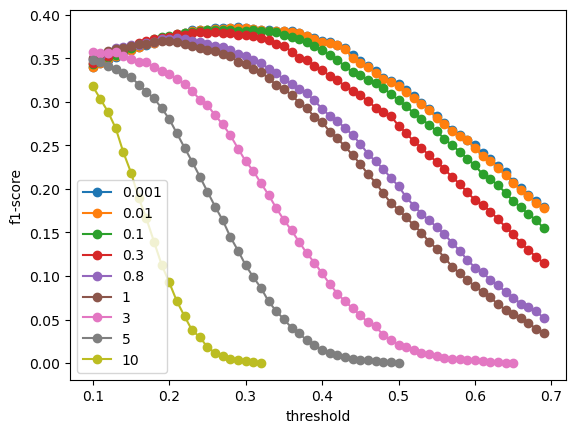

In [87]:
thr_l=np.arange(0.1,0.7,0.01)
for lambda_ in [0.001,0.01,0.1,0.3,0.8,1,3,5,10]:
    w_opt,loss=ridge_regression(y_tra1,x_tra_scaled1,lambda_=lambda_)
    
    f1_scores=[compute_scores(x_val_scaled,w_opt,y_val,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend()
plt.show()

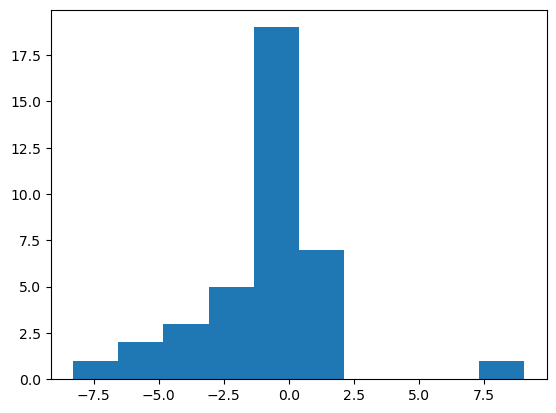

In [52]:
plt.hist(w_opt*100)
plt.show()

### Logistic regression

In [76]:
w_opt_log,loss=logistic_regression(y_tra1,x_tra_scaled1,initial_w=np.zeros((x_tra_scaled1.shape[1],1)),max_iters=15,gamma=0.2,gd=True)

In [79]:
compute_scores(x_val_scaled,w_opt_log,y_val,threshold=0.68,apply_sigmoid=True)

(0.3025217391304348, 0.4872549019607843, 0.3732832618025751)

In [100]:
thr_l=np.arange(0.3,0.75,0.01)
f1_scores=[compute_scores(x_val_scaled,w_opt_log,y_val,threshold=t,apply_sigmoid=True)[2] for t in thr_l]
plt.plot(thr_l,f1_scores,marker='o')
plt.xlabel("threshold")
plt.ylabel("f1-score")

NameError: name 'w_opt_log' is not defined